### Confidence Intervals Predictions with quantile-method  

In this notebook we will make,compare and evaluate confidence intervals for time series forecasting task.

In [4]:
import fbprophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

# Additional imports are required
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Plots
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import logging
logging.raiseExceptions = False

In [5]:
# date uploading
df = pd.read_csv('ts study 1.txt')
d = df[df['label'] == 'traffic_volume'].drop('label',axis=1).rename(columns = {'datetime':'ds', 'value':'y'})

In [6]:
d

,ds,y
17520,2016-10-01 00:00:00,1195.0
17521,2016-10-01 01:00:00,776.0
17522,2016-10-01 02:00:00,666.0
17523,2016-10-01 03:00:00,448.0
17524,2016-10-01 04:00:00,512.0
...,...,...
35035,2018-09-30 19:00:00,3543.0
35036,2018-09-30 20:00:00,2781.0
35037,2018-09-30 21:00:00,2159.0
35038,2018-09-30 22:00:00,1450.0


In [7]:
# train and test series
train  = d[:-336]
test = d[-336:]

We have a daily and weekly periodical time series of traffic volume observations. The typical behaviour of this
ts is plotted below:

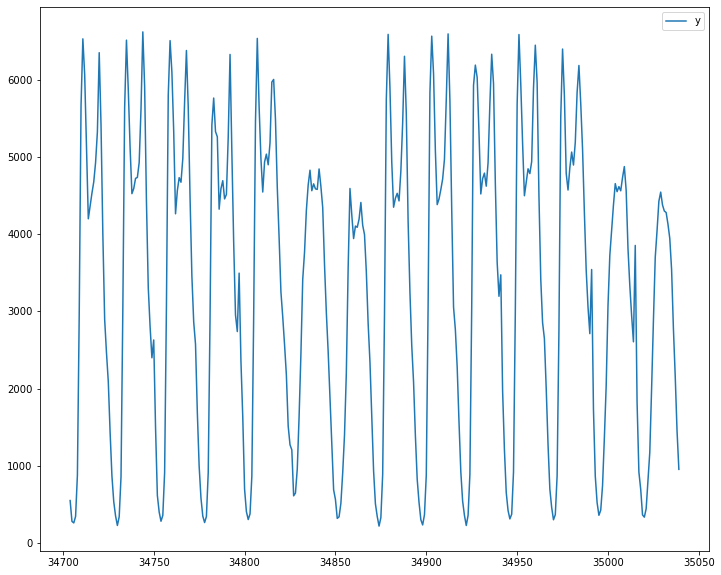

In [8]:
test.plot();

We take some model that performs well on this ts and use it.

In [9]:
model = Prophet(weekly_seasonality = True, daily_seasonality = True)
model.fit(train);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -1397.23
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       28391.1   0.000476144       122.934           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       28400.3    0.00763476       270.327          10           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       28405.1    0.00621569        131.72      0.5665      0.5665      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       28407.4   0.000372137       497.625   1.011e-06       0.001      533  LS failed, Hessian reset 
     399       28407.9    0.00189935       155.918           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     430       28408.7   6.57586e-05    

Now we are start working on the residuals of the model on training set. 

In [10]:
# create residuals of the model on the trainig set
train_preds = model.predict(train)['yhat']
train_preds = pd.Series(np.array(train_preds),index = range(17520,34704))

resids = train_preds-train['y']

Plot histogramm of the residuals. As wee see, the distribution of the residuals below does not seem to be normal, since it has to sharp mode at 0 and non-symmetricals positive and negative parts. But, this does not affect our approach.

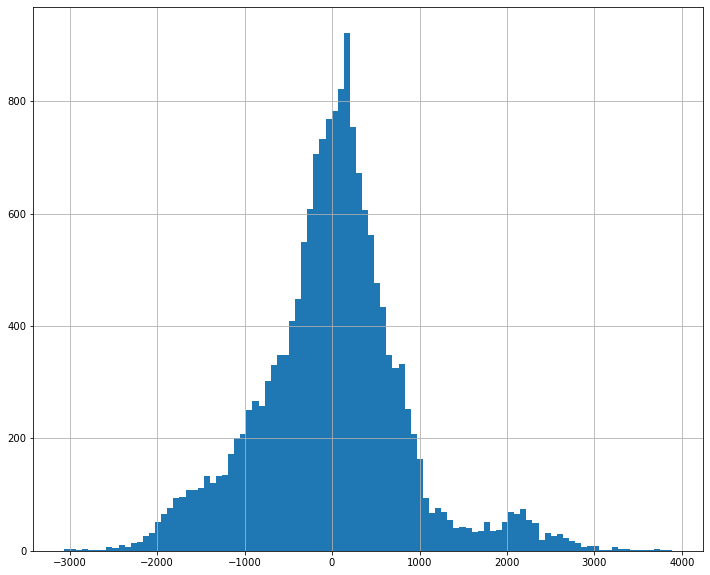

In [11]:
resids.hist(bins=100);

In [12]:
resids.std()

842.4481896029936

We take quantiles of the distribution of the residuals below

In [13]:
# take quantile of the residuals
up_quantile = np.quantile(resids, 0.925)
low_quantile = np.quantile(resids, 0.075)

As low bound point of our confidence interval we take low_quantile + predicions,
for upper bound we take upper_quantile +predictions. Here we take default facebook predictions + facebook confidence intervals

In [14]:
# predictions
future = model.make_future_dataframe(periods = 336, freq = 'H',include_history = False)
all_pred = model.predict(future)
pred = all_pred['yhat']

lower = all_pred['yhat_lower']
upper = all_pred['yhat_upper']

up_conf_int = pred+up_quantile
low_conf_int = pred+low_quantile

Next we plot several plots, that show performance of our and fb results.

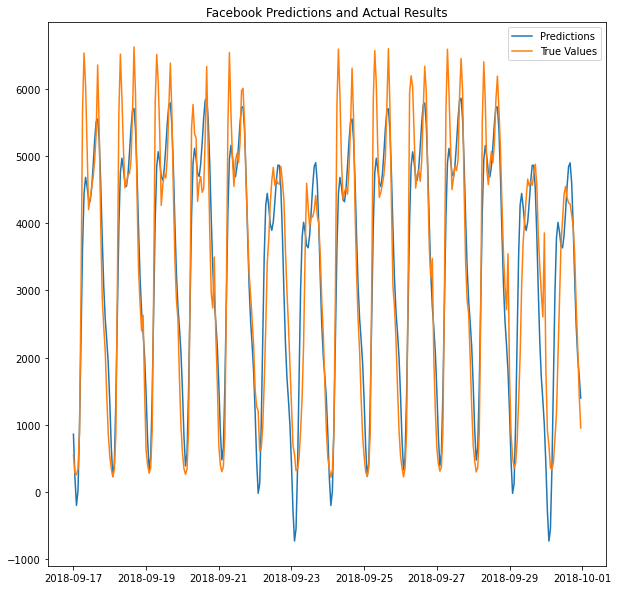

In [15]:
#Plotting the results; from this plot we see that the facebook model performs well

fig,ax = plt.subplots()
ax.plot(future['ds'], pred, label = 'Predictions')
ax.plot(future['ds'], test['y'], label = 'True Values')
ax.set_title('Facebook Predictions and Actual Results')
fig.set(figwidth = 10, figheight = 10)
plt.legend();

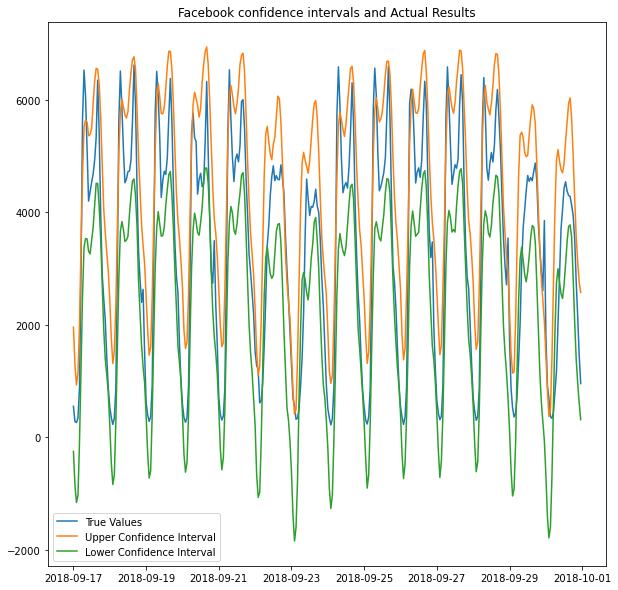

In [16]:
# here we plot facebook confidence intervals and actual values

fig,ax = plt.subplots()
ax.plot(future['ds'], test['y'], label = 'True Values')
ax.set_title('Facebook confidence intervals and Actual Results')
ax.plot(future['ds'], upper, label = 'Upper Confidence Interval')
ax.plot(future['ds'], lower,label =  'Lower Confidence Interval')
fig.set(figwidth = 10, figheight = 10)
plt.legend();

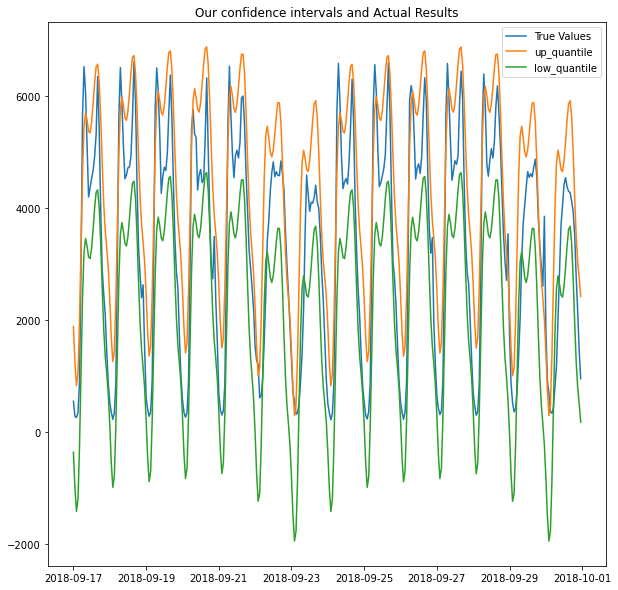

In [17]:
# here we see our confidence intervals and actual values
fig,ax = plt.subplots()
ax.plot(future['ds'], test['y'], label = 'True Values')
ax.set_title('Our confidence intervals and Actual Results')
ax.plot(future['ds'],up_conf_int,label = 'up_quantile')
ax.plot(future['ds'],low_conf_int,label = 'low_quantile')
fig.set(figwidth = 10, figheight = 10)
plt.legend();

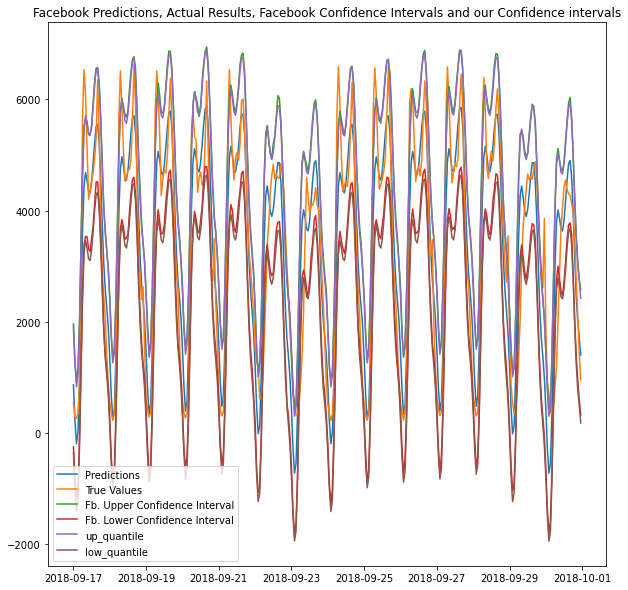

In [18]:
# Here we see everything on the same plot

fig,ax = plt.subplots()
ax.plot(future['ds'], pred, label = 'Predictions')
ax.plot(future['ds'], test['y'], label = 'True Values')
ax.set_title('Facebook Predictions, Actual Results, Facebook Confidence Intervals and our Confidence intervals')
ax.plot(future['ds'], upper, label = 'Fb. Upper Confidence Interval')
ax.plot(future['ds'], lower,label =  'Fb. Lower Confidence Interval')
ax.plot(future['ds'],up_conf_int,label = 'up_quantile')
ax.plot(future['ds'],low_conf_int,label = 'low_quantile')
fig.set(figwidth = 10, figheight = 10)
plt.legend();

Here we numerically evaluate our results. We create a metric that can compare perforamce of the confidence
intervals

In [19]:
# This is the prototype of metrics that evaluates robustness of confidence intervals. 
def interval_metric(values,up, low):
    values = np.array(values)
    up = np.array(up)
    low = np.array(low)
    lv = len(values)
    if lv != len(up) or lv != len(low):
        print('ERROR! Arrays have different length!')
    for i in range(lv):
        if up[i]<low[i]:
            print('ERROR! Confidence intervals are not correct!')
    else:    
        u = 0
        l = 0
        for i in range(lv):
            if values[i] > up[i]:
                u +=1
            if values[i] < low[i]:
                l+=1
        gap = up-low
        average_gap = gap.mean()
        ans = {'total_upper_error': u,
               'total_lower_error': l,
               'total_error' : l+u,
               'percent_upper_error':u/lv,
               'percent_lower_error': l/lv,
               'percent_error': (u+l)/lv,
               'average_gap': average_gap}
        
        return ans

In [20]:
interval_metric(test['y'],upper,lower)

{'total_upper_error': 35,
 'total_lower_error': 19,
 'total_error': 54,
 'percent_upper_error': 0.10416666666666667,
 'percent_lower_error': 0.05654761904761905,
 'percent_error': 0.16071428571428573,
 'average_gap': 2156.5813241611127}

In [21]:
interval_metric(test['y'],up_conf_int,low_conf_int)

{'total_upper_error': 37,
 'total_lower_error': 14,
 'total_error': 51,
 'percent_upper_error': 0.11011904761904762,
 'percent_lower_error': 0.041666666666666664,
 'percent_error': 0.15178571428571427,
 'average_gap': 2245.964222864946}

In [22]:
#Some metrics of fb predictions
mae(test['y'], pred), np.sqrt(mse(test['y'],pred)), test['y'].std()

(598.5322720670208, 803.8999620330238, 1965.7025461628507)

## Application to Fedot

Fitst we import necessary packages:

In [23]:
import fedot

from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.data.data import InputData
from fedot.core.pipelines.ts_wrappers import fitted_values,in_sample_fitted_values
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

The function below takes fedot model and returns its predictions on the train data.

In [40]:
def ts_train_preds(model, train_data,plot_fitted = False, plot_ts = False):
    """ 
    input
    model: a fedot model
    train_data: a csv file with ts-train data. Target must be 'value'
    plot_fitted, plot_ts: parameters whether or not to plot fitted train values \ actual ts
    
    output
    np.array consisting of predictions on train dataset.
    
    Warning! The array of predictions typically are shorter than inital ts.
    """
    
    len_forecast = 2
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))
    
    ts_input = InputData.from_csv_time_series(file_path=train_data,task=task, target_column='value')
    train_predicted = model.fit(ts_input)
    fitted_ts_act = fitted_values(ts_input, train_predicted)
    if plot_fitted or plot_ts:
        if plot_fitted:
            plt.plot(fitted_ts_act.idx, fitted_ts_act.predict, label='Fitted values all')
        if plot_ts:
            plt.plot(range(len(ts_input.idx)), ts_input.target, label='Actual time series')
        plt.legend()
        plt.grid()
        plt.show()
        
    #in_sample_validated = in_sample_fitted_values(ts_input, train_predicted)
    ans = {'actual':ts_input.target,
           'fitted':fitted_ts_act.predict}
    return ans

The function below computes the residuals of the model starting from the first observation that can be predicted
by the model.

Typically this is not the first observation!

In [41]:
def resids(model,train_data, plot=False, hist = False):
    '''
    input
    model: a fedot ts model
    train_data: a csv file containing ts with target column 'value'
    
    output
    np.array of residuals
    '''
    x = fv(model, train_data,plot_fitted = False, plot_ts = False)
    
    train_preds = x['fitted']
    actual = x['actual']
    
    dif_len = len(x['actual'])-len(train_preds)
    
    resids = actual[dif_len:]-train_preds
    if plot:
        plt.plot(resids, label='Resids');
    if hist:
        resid = pd.Series(resids)
        resid.hist(bins=100);
    return resids

This function takes model and computes confidence intervals

In [28]:
def quantiles(model, train_data, alpha = 0.05, method = 'median_unbiased'):
    residuals = resids(model, train_data)
    up_quantile = np.quantile(residuals, 1-alpha/2, method = method)
    low_quantile = np.quantile(residuals, alpha/2, method = method)
    ans = {'up':up_quantile,
           'low': low_quantile}
    return ans

Let us implement our approach on some dataset. First we create train and test datasets.

In [30]:
d = pd.read_csv('ocean.csv')

In [31]:
len_forecast = 100
d_train = d[:-len_forecast ]
d_test = d[-len_forecast:]
d_train.to_csv('ocean_train.csv', index= False)
d_test.to_csv('ocean_test.csv', index = False)

Make some model:

In [78]:
node_1 = PrimaryNode('lagged')
node_2 = SecondaryNode('ridge', nodes_from = [node_1])
node_3 = SecondaryNode('rfr', nodes_from=[node_1]) #other nodes are https://github.com/nccr-itmo/FEDOT/blob/master/fedot/core/operations/hyperparameters_preprocessing.py
node_4 = SecondaryNode('xgbreg', nodes_from=[node_2,node_3])
pipeline = Pipeline(node_4)

n1 = PrimaryNode('lagged')
n2 = SecondaryNode('ridge', nodes_from = [node_1])
pipeline2 = Pipeline(n2)

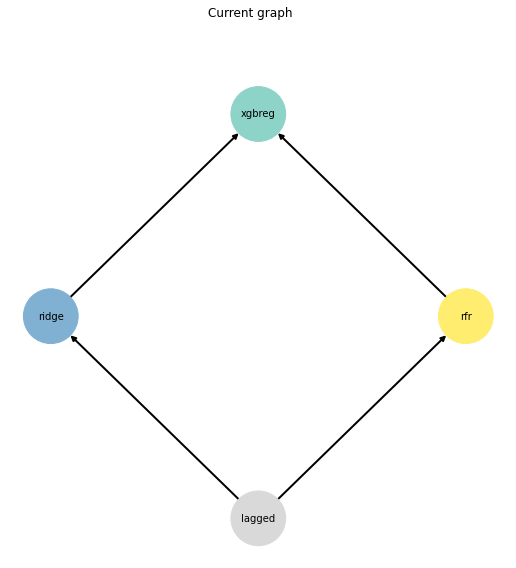

In [88]:
pipeline.show()

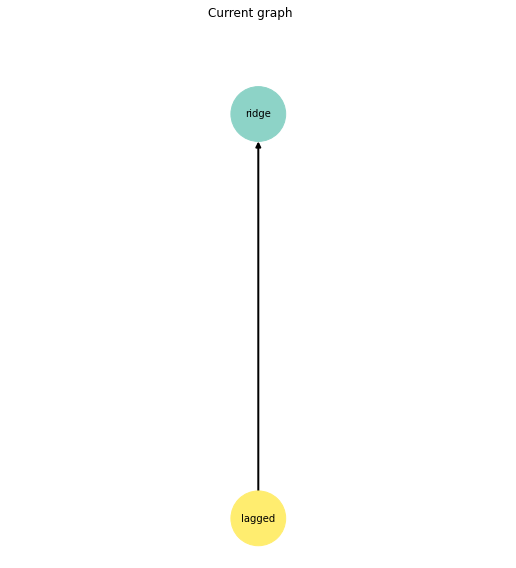

In [89]:
pipeline2.show()

Compute the quantiles:

In [82]:
q=quantiles(pipeline, 'ocean_train.csv')
q2 = quantiles(pipeline2, 'ocean_train.csv')
q,q2

({'up': 0.9098180135091148, 'low': -0.926630401611328},
 {'up': 5.2954342417678095, 'low': -4.559202556657364})

Fit and forecast using the model:

In [70]:
train_data = np.array(pd.read_csv('ocean_train.csv')['value'])
test_data = np.array(pd.read_csv('ocean_test.csv')['value'])
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_forecast))
# Prepare data to train the model
train_input = InputData(idx=np.arange(0, len(train_data)),
                        features=train_data,
                        target=train_data,
                        task=task,
                        data_type=DataTypesEnum.ts)

# Prepare input data for prediction part
start_forecast = len(train_data)
end_forecast = start_forecast + len_forecast
# Create forecast indices 
forecast_idx = np.arange(start_forecast, end_forecast)
predict_input = InputData(idx=forecast_idx,
                          features=train_data,
                          target=test_data,
                          task=task,
                          data_type=DataTypesEnum.ts)

In [83]:
pipeline.fit(train_input)
# Predict. Pipeline return OutputData object 
predicted_output = pipeline.predict(predict_input)

# Convert forecasted values into one-dimensional array
forecast = np.ravel(np.array(predicted_output.predict))

pipeline2.fit(train_input)
# Predict. Pipeline return OutputData object 
predicted_output2 = pipeline2.predict(predict_input)

# Convert forecasted values into one-dimensional array
forecast2 = np.ravel(np.array(predicted_output2.predict))

See the results:

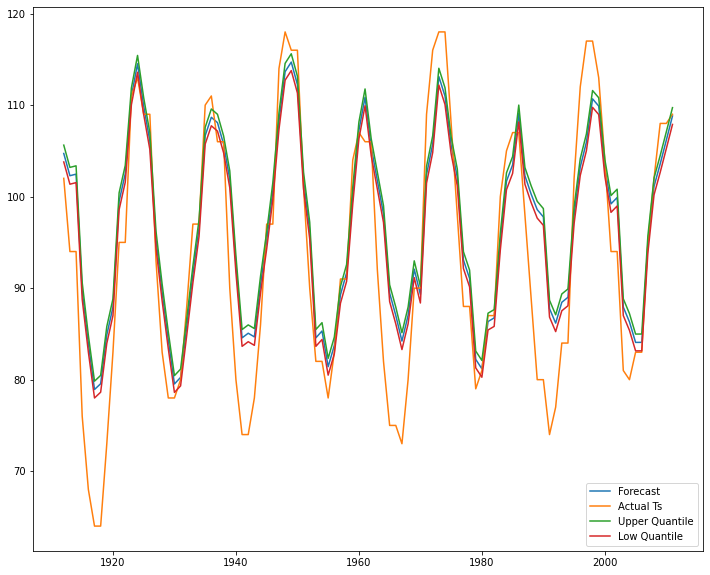

In [84]:
fig,ax = plt.subplots()
#ax.plot(np.arange(0, len(train_data)), train_data, label = 'Train')
ax.plot(np.arange(len(train_data), len(train_data)+len(forecast)) , forecast, label = 'Forecast')
ax.plot(np.arange(len(train_data), len(train_data)+len(forecast)) , test_data, label = 'Actual Ts')
ax.plot(np.arange(len(train_data), len(train_data)+len(forecast)) , forecast+q['up'], label = 'Upper Quantile')
ax.plot(np.arange(len(train_data), len(train_data)+len(forecast)) , forecast+q['low'], label = 'Low Quantile')
ax.legend();

Numerical performance:

In [91]:
interval_metric(values = test_data,up=forecast+q['up'], low=forecast+q['low'])

{'total_upper_error': 27,
 'total_lower_error': 55,
 'total_error': 82,
 'percent_upper_error': 0.27,
 'percent_lower_error': 0.55,
 'percent_error': 0.82,
 'average_gap': 1.836449}

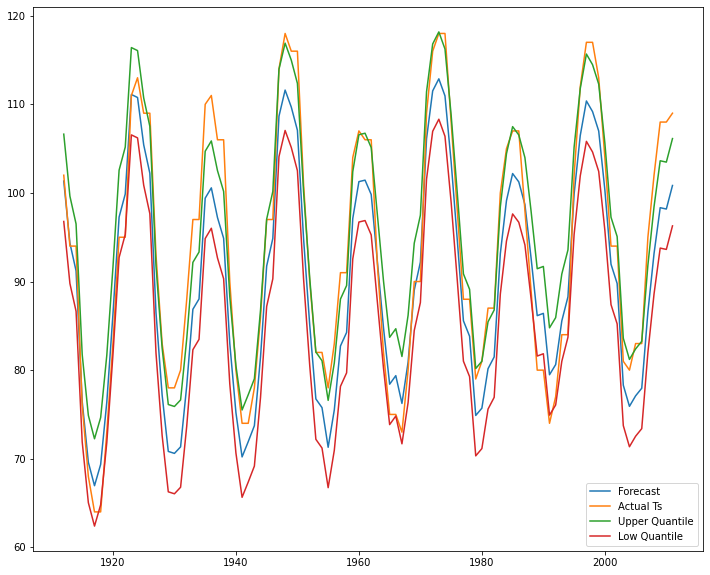

In [92]:
fig,ax = plt.subplots()
#ax.plot(np.arange(0, len(train_data)), train_data, label = 'Train')
ax.plot(np.arange(len(train_data), len(train_data)+len(forecast2)) , forecast2, label = 'Forecast')
ax.plot(np.arange(len(train_data), len(train_data)+len(forecast2)) , test_data, label = 'Actual Ts')
ax.plot(np.arange(len(train_data), len(train_data)+len(forecast2)) , forecast2+q2['up'], label = 'Upper Quantile')
ax.plot(np.arange(len(train_data), len(train_data)+len(forecast2)) , forecast2+q2['low'], label = 'Low Quantile')
ax.legend();

In [87]:
interval_metric(values = test_data,up=forecast2+q2['up'], low=forecast2+q2['low'])

{'total_upper_error': 43,
 'total_lower_error': 5,
 'total_error': 48,
 'percent_upper_error': 0.43,
 'percent_lower_error': 0.05,
 'percent_error': 0.48,
 'average_gap': 9.854636798425176}